<a href="https://colab.research.google.com/github/kayteeflick/nma_cn_flow_state/blob/updated_lfp_indexing/template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow State Template Analysis File

General functions to use in all notebooks. Make a copy of this to start a new type of analysis.




## Imports

In [250]:
#title 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, filtfilt
from scipy import signal
from statsmodels.tsa.api import VAR

## Data Retrieval - spikes

In [251]:
#title Data retrieval - spikes
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

## Data retrieval - LFP

In [252]:
 
import os, requests

fname = ['steinmetz_st.npz']
fname.append('steinmetz_wav.npz')
fname.append('steinmetz_lfp.npz')

url = ["https://osf.io/4bjns/download"]
url.append("https://osf.io/ugm9v/download")
url.append("https://osf.io/kx3v9/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']


`dat_LFP`, `dat_WAV`, `dat_ST` contain 39 sessions from 10 mice, data from Steinmetz et al, 2019, supplemental to the main data provided for NMA. Time bins for all measurements are 10ms, starting 500ms before stimulus onset (same as the main data). The followin fields are available across the three supplemental files. 

* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['ss']`: neurons by trials. Exact spikes times for each neuron and each trial, reference to the stimulus onset. A (neuron,trial) entry can be an empty list if that neuron did not fire at all on that trial. 
* `dat['%X%_passive']`: same as above for `X` = {`lfp`, `ss`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




## Functions

In [253]:
# commmon functions

def select_brois(data, brois, data_type, selection=True):
  '''
  Args:
    data: a numpy array of the Steinmetz 2019 data
    brois: a list of brain regions of interest
    data_type: "LFP" or "spikes"
    selection: if True, filters for sessions that contain all brois. If False, filters
        for sessions that contain any of the brois
  Returns:
    an embedded 1-d numpy array, with length = number of filtered session
  '''
  selected_data = np.array([])

  if data_type == "LFP":
    brain_area = "brain_area_lfp"
  elif data_type == "spikes":
    brain_area = "brain_area"

  if selection == True:
    for i in range(len(data)):
      if all(item in data[i][brain_area] for item in brois):
        selected_data = np.hstack((selected_data, data[i]))
  else:
    for i in range(len(data)):
      if any(item in data[i][brain_area] for item in brois):
        selected_data = np.hstack((selected_data, data[i]))

  return selected_data

def sel_neurons():
  print('todo')
  return

def spks_to_rate(spks):
  print('todo')
  return

def butter_bandpass_backend(lowcut, highcut, fs, order=6):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

def butter_bandpass_filter_good_func(data, lowcut, highcut, fs, order=6):
  b, a = butter_bandpass_backend(lowcut, highcut, fs, order=order)
  y = filtfilt(b, a, data)
  return y 

def get_behavioral_idx(recording_session):
  '''
  Args:
    alldat: spiking data as loaded in originally 
    recording session: what recording session as an integer you want to pull behavioral indices for 
  Returns:
    series of arrays that you can use to index behavior 
  '''
  response = recording_session['response'] # right - nogo - left (-1, 0, 1)
  vis_right = recording_session['contrast_right'] # 0 - low - high
  vis_left = recording_session['contrast_left'] # 0 - low - high
  gocue_idx = recording_session['gocue']
  rt_idx = recording_session['reaction_time']
  is_correct = np.sign(response)==np.sign(vis_left-vis_right)
  return response, vis_right, vis_left, gocue_idx, rt_idx, is_correct

def concatenate_lfp(brain_area_raw_dat,zeropadsize=0): 
  '''
  Args:
    data: a 2d array of raw brain area LFP should be 2d after you select a specific session and area to pull. 
    zeropadsize: if you'd like to add padding to the concatenation. Default is 0 (no padding)
  Returns:
    1D Array of Concatenated trials for a given brain area recording. 
  '''
  concatenated_data = np.array([])
  N = zeropadsize
  for i in range(len(brain_area_raw_dat)):
    single_trial = brain_area_raw_dat[i,:]
    trial_padded = np.pad(single_trial,(N,N),'constant')
    concatenated_data = np.concatenate([concatenated_data,trial_padded])
  return concatenated_data

def spikes_avg(data):
  '''
  Args:
    data: a single session data frame from Steinmetz 2019 data
  Returns:
    A 2d numpy array of trial averages. Rows are neurons. Column are time step
  '''
  avg = np.mean(data['spks'], axis = 1)

  return avg

def add_avg(data):
  '''
  Adds the trial average to the data structure

  Args: 
    data: a single session dataframe from Steinmetz
  '''
  data["spks_avg"] = spikes_avg(data)
  return data

def multi_add_avg(alldat):
  """
  Adds trial averages to all sessions in the dataframe
  Args:
    alldat: a numpy array of sessions
  """
  for i in range(len(alldat)):
    alldat[i] = add_avg(alldat[i])
  return alldat

def concat_trials(data, bin_start, bin_end):
  """
  Args:
    data: a single session data frame from Steinmetz 2019 data
    bin_start, bin_end: integers indicating which bin to start and end at
  Returns:
    A 2d numpy array of with trials concatenated horizontally with shape N×TK 
    (number of neurons by number of time points times number of trials).
  """   
  NN = len(data['spks'][0])
  X = np.reshape(data['spks'][:,:,bin_start:bin_end], (NN,-1))

  return X

def trial_result(data):
  '''
  Args:
    data: a single session data frame
  Returns:
    numpy logical arrarys corresponding to right trials, correct right, incorrect
    right trials, miss right trials, no_go trials
  '''
  # response: right - nogo - left (-1, 0, 1)
  # vis left/right 0 - low - high
  response, vis_right, vis_left, gocue_idx, rt_idx, is_correct = get_behavioral_idx(data)
  ind = {}

  # trial types
  ind["right_go"] = np.array(vis_right > vis_left)
  ind["left_go"] = np.array(vis_left > vis_right)
  ind["nogo"] = np.logical_and(vis_left == 0, vis_right == 0)
  ind["equal"] = np.logical_and(vis_right >0, vis_right == vis_left)

  # right trials by response
  ind["right_cor"] = np.logical_and(response == -1, vis_right > vis_left)
  ind["right_error"] = np.logical_and(response == 1, vis_right > vis_left)
  ind["right_miss"] = np.logical_and(response == 0, vis_right > vis_left)

  # left trials by response
  ind["left_cor"] = np.logical_and(response == 1, vis_right < vis_left)
  ind["left_error"] = np.logical_and(response == -1, vis_right < vis_left)
  ind["left_miss"] = np.logical_and(response == 0, vis_right < vis_left)

  # nogo trials by response
  ind["nogo_cor"] = np.logical_and(response == 0, ind["nogo"])
  ind["nogo_error"] = np.logical_and(response != 0, ind["nogo"])
  # difficulty 
  ind["difficulty"] = np.array(abs(vis_left-vis_right))

  return ind

def frequencyband_coherence_analysis(raw_dat,correct_idx,region_of_interest,timepoints,freq_band,corr):
  '''
  Args:
    raw_dat = array of LFP data for a specific session you would like to look at should be (brain_area,340,250)
    correct_idx = idx of correct or incorrect trials to look at one vector so dimension should match second dimension ie. len = 340 
    region_of_interest = (i = 1:12) what brain area you'd like to look at in a digit form. if using loop can go through all brain areas and do pair wise comparison. 
    timepoints =  (tp = [0,50]) what timepoints you'd like to run the coherence analysis over
    freq_band =  (fb = [5,8]) --> Theta, What frequence band you'd like to average coherence analysis over. 
  Returns:
    should return a vector for each comparison you chose to do. 
  '''

  coherence_array = np.empty((raw_dat.shape[0]))
  zeropadsize = 0 

  for i in range(raw_dat.shape[0]):

    if corr == 1:
      brain_area_1 = raw_dat[region_of_interest,correct_idx==1,timepoints[0]:timepoints[1]] # 1 is correct response
      brain_area_2 = raw_dat [i,correct_idx==1,timepoints[0]:timepoints[1]]
    else:
      brain_area_1 = raw_dat[region_of_interest,correct_idx==0,timepoints[0]:timepoints[1]] # 1 is correct response
      brain_area_2 = raw_dat [i,correct_idx==0,timepoints[0]:timepoints[1]]

    brain_area_1 = concatenate_lfp(brain_area_1,zeropadsize)
    brain_area_2 = concatenate_lfp(brain_area_2,zeropadsize)
    f, Cxy = signal.coherence(brain_area_1, brain_area_2, 100, nperseg=100)
    Cxy_avg = np.mean(Cxy[freq_band[0]:freq_band[1]])
    coherence_array[i] = Cxy_avg

  return coherence_array




## Testing Coherence Function with new indices 

In [254]:
#@title Pulling relevant indices 
temp_dat = alldat[11]
idx = trial_result(temp_dat) 
print(idx.keys())

dict_keys(['right_go', 'left_go', 'nogo', 'equal', 'right_cor', 'right_error', 'right_miss', 'left_cor', 'left_error', 'left_miss', 'nogo_cor', 'nogo_error', 'difficulty'])


In [255]:
#@title Running coherence @ Theta Right Correct Trials 
#pulling data and idx of interest
session11 = dat_LFP[11]
session11_lfp = session11['lfp']
correct_right_idx = idx['right_cor']

#parameters 
timepoints = [0,50]
fb = [5,8]

#running analysis 
theta_array = np.empty([12,12])
for i in range(theta_array.shape[0]): 

  theta_array[i,:] = frequencyband_coherence_analysis(session11_lfp,correct_right_idx,i,timepoints,fb,1)

Text(0.5, 1.0, 'Theta Coherence Right Correct Trials Pre Stim')

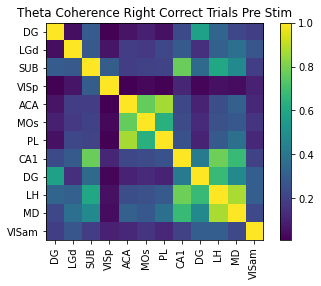

In [256]:
#@title Plotting Coherence 
positions = (0,1, 2, 3,4,5,6,7,8,9,10,11)
labels = session11['brain_area_lfp']
plt.xticks(positions, labels,rotation = 'vertical')
plt.yticks(positions, labels)
plt.imshow(theta_array)
plt.colorbar()
plt.title('Theta Coherence Right Correct Trials Pre Stim')


In [257]:
#@title Repeating analysis for error trials 
#parameters 
timepoints = [0,50]
fb = [5,8]

#running analysis 
theta_array_incorr = np.empty([12,12])
for i in range(theta_array.shape[0]): 

  theta_array_incorr[i,:] = frequencyband_coherence_analysis(session11_lfp,correct_right_idx,i,timepoints,fb,0)

Text(0.5, 1.0, 'Theta Coherence Right Incorrect Trials Pre Stim')

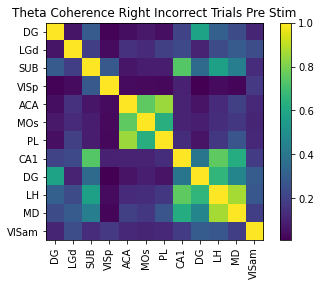

In [258]:
#@title Plotting Incorrect Coherence 
positions = (0,1, 2, 3,4,5,6,7,8,9,10,11)
labels = session11['brain_area_lfp']
plt.xticks(positions, labels,rotation = 'vertical')
plt.yticks(positions, labels)
plt.imshow(theta_array_incorr)
plt.colorbar()
plt.title('Theta Coherence Right Incorrect Trials Pre Stim')

Text(0.5, 1.0, 'Theta Coherence Corr - Incorr: -500 - 0 ms')

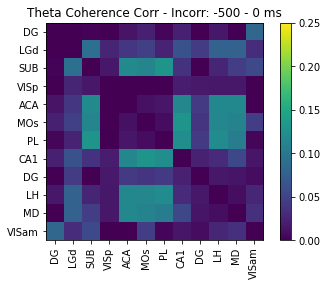

In [259]:
#@title Difference matrix @ right trials 
difference_coherence = np.subtract(theta_array,theta_array_incorr)
plt.imshow(difference_coherence)
positions = (0,1, 2, 3,4,5,6,7,8,9,10,11)
labels = session11['brain_area_lfp']
plt.xticks(positions, labels,rotation = 'vertical')
plt.yticks(positions, labels)
plt.colorbar()
plt.clim(0,.25) 
plt.title('Theta Coherence Corr - Incorr: -500 - 0 ms')

In [260]:
#@title repeating analysis at stim onset till 500 ms out. 
timepoints = [51,100]
fb = [5,8]
#running analysis 
theta_array_stimon = np.empty([12,12])
theta_array_stimon_incorr = np.empty([12,12])
for i in range(theta_array_stimon.shape[0]): 

  theta_array_stimon[i,:] = frequencyband_coherence_analysis(session11_lfp,correct_right_idx,i,timepoints,fb,1)
  theta_array_stimon_incorr[i,:] = frequencyband_coherence_analysis(session11_lfp,correct_right_idx,i,timepoints,fb,0)


Text(0.5, 1.0, 'Theta Coherence Corr - Incorr: 0 - 500 ms ')

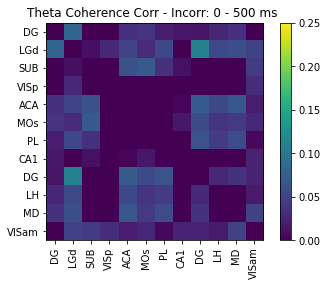

In [261]:
#@title Plotting again 
difference_coherence_stimon = np.subtract(theta_array_stimon,theta_array_stimon_incorr)
plt.imshow(difference_coherence_stimon)
positions = (0,1, 2, 3,4,5,6,7,8,9,10,11)
labels = session11['brain_area_lfp']
plt.xticks(positions, labels,rotation = 'vertical')
plt.yticks(positions, labels)
plt.colorbar()
plt.clim(0,.25) 
plt.title('Theta Coherence Corr - Incorr: 0 - 500 ms ')

In [262]:
#@title Repeating Process one more time for gamma 
#parameters 
timepoints = [0,50]
fb = [30,50]

#running analysis 
gamma_array = np.empty([12,12])
gamma_array_incorr = np.empty([12,12])
for i in range(gamma_array.shape[0]): 

  gamma_array[i,:] = frequencyband_coherence_analysis(session11_lfp,correct_right_idx,i,timepoints,fb,1)
  gamma_array_incorr[i,:] = frequencyband_coherence_analysis(session11_lfp,correct_right_idx,i,timepoints,fb,0)

Text(0.5, 1.0, 'Gamma Coherence Corr - Incorr: 0 - 500 ms ')

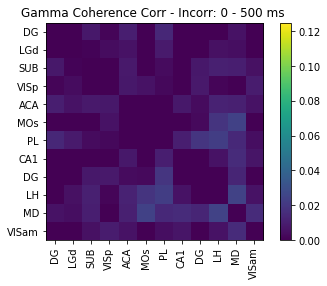

In [263]:
#@title Plotting gamma diff 
difference_coherence_gamma = np.subtract(gamma_array,gamma_array_incorr)
plt.imshow(difference_coherence_gamma)
positions = (0,1, 2, 3,4,5,6,7,8,9,10,11)
labels = session11['brain_area_lfp']
plt.xticks(positions, labels,rotation = 'vertical')
plt.yticks(positions, labels)
plt.colorbar()
plt.clim(0,.125) 
plt.title('Gamma Coherence Corr - Incorr: 0 - 500 ms ')

In [264]:
#@title Trying difficulty index. 

#pulling data and idx of interest
session11 = dat_LFP[11]
session11_lfp = session11['lfp']
diff_idx = idx['difficulty']

low_diff_idx = diff_idx == 0.25
low_med_diff_idx = diff_idx == 0.5 
high_med_diff_idx = diff_idx == 0.75
high_diff_idx = diff_idx == 1
#parameters 
timepoints = [51,100]
fb = [5,8]


#running analysis 
theta_array_low = np.empty([12,12])
theta_array_low_med = np.empty([12,12])
theta_array_high_med = np.empty([12,12])
theta_array_high = np.empty([12,12])

for i in range(theta_array_low.shape[0]): 

  theta_array_low[i,:] = frequencyband_coherence_analysis(session11_lfp,low_diff_idx,i,timepoints,fb,1)
  theta_array_low_med[i,:] = frequencyband_coherence_analysis(session11_lfp,low_med_diff_idx,i,timepoints,fb,1)
  theta_array_high_med[i,:] = frequencyband_coherence_analysis(session11_lfp,high_med_diff_idx,i,timepoints,fb,1)
  theta_array_high[i,:] = frequencyband_coherence_analysis(session11_lfp,high_diff_idx,i,timepoints,fb,1)

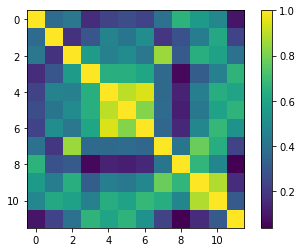

In [265]:
#@title Plotting difficulty 
plt.imshow(theta_array_low)
# positions = (0,1, 2, 3,4,5,6,7,8,9,10,11)
# labels = session11['brain_area_lfp']
# plt.xticks(positions, labels,rotation = 'vertical')
# plt.yticks(positions, labels)
plt.colorbar()
#plt.clim(0,.25) 

Text(0.5, 1.0, 'Theta low - high diff: 0 - 100 ms ')

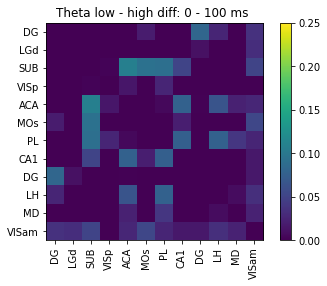

In [266]:
difference_coherence_diff = np.subtract(theta_array_low,theta_array_high)
plt.imshow(difference_coherence_diff)
plt.colorbar()
positions = (0,1, 2, 3,4,5,6,7,8,9,10,11)
labels = session11['brain_area_lfp']
plt.xticks(positions, labels,rotation = 'vertical')
plt.yticks(positions, labels)
plt.clim(0,.25) 
plt.title('Theta low - high diff: 0 - 100 ms ')

In [267]:
# obtain the lag P for VAR
session11_lfp.shape
brain_area_1 = concatenate_lfp(session11_lfp[6,:,:],0)
brain_area_2 = concatenate_lfp(session11_lfp[7,:,:],0)
rawData = np.column_stack((brain_area_1, brain_area_2))


model = VAR(rawData) #recall that rawData is w/o difference operation

for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue


Lag Order = 1
AIC :  9.815193459386332
BIC :  9.815853495017624
FPE :  18309.831946424776
HQIC:  9.815395238587248 

Lag Order = 2
AIC :  9.792766638237259
BIC :  9.793866709180785
FPE :  17903.770967871922
HQIC:  9.793102940618105 

Lag Order = 3
AIC :  9.773462960218955
BIC :  9.775003075721505
FPE :  17561.476735707936
HQIC:  9.773933788749977 

Lag Order = 4
AIC :  9.759869847083866
BIC :  9.761850016392536
FPE :  17324.376710160865
HQIC:  9.760475204735403 

Lag Order = 5
AIC :  9.749687051657203
BIC :  9.752107284019397
FPE :  17148.861261789094
HQIC:  9.750426941399702 

Lag Order = 6
AIC :  9.742131028322907
BIC :  9.744991332986336
FPE :  17019.772379451413
HQIC:  9.743005453126912 

Lag Order = 7
AIC :  9.73680499162819
BIC :  9.74010537784087
FPE :  16929.36541637945
HQIC:  9.737813954464347 

Lag Order = 8
AIC :  9.736292975948539
BIC :  9.74003345295879
FPE :  16920.69953461923
HQIC:  9.737436479787595 

Lag Order = 9
AIC :  9.735583419573695
BIC :  9.739763996630154
FPE :

In [268]:
!pip install nitime
import nitime
import nitime.analysis as nta
import nitime.timeseries as ts
import nitime.utils as tsu
from nitime.viz import drawmatrix_channels


In [269]:
#@title Trying different package for Granger 
!pip install spectral_connectivity

     |████████████████████████████████| 44 kB 1.6 MB/s 


Text(0.5, 1.0, 'Correlation Between Brain Areas Theta: -500 - 0 ms')

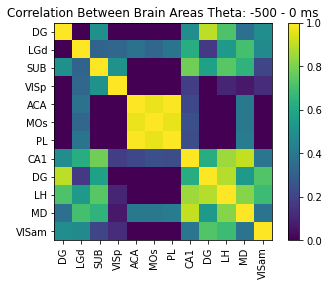

In [270]:
#@title Getting nowhere going back to Correlation calculation 

from scipy import stats
rho, pval = stats.spearmanr(theta_array, theta_array)
plt.imshow(rho[0:12,0:12])
plt.colorbar()
positions = (0,1, 2, 3,4,5,6,7,8,9,10,11)
labels = session11['brain_area_lfp']
plt.xticks(positions, labels,rotation = 'vertical')
plt.yticks(positions, labels)
plt.clim(0,1) 
plt.title('Correlation Between Brain Areas Theta: -500 - 0 ms')

Text(0.5, 1.0, 'Correlation Between Brain Areas Theta: -500 - 0 ms')

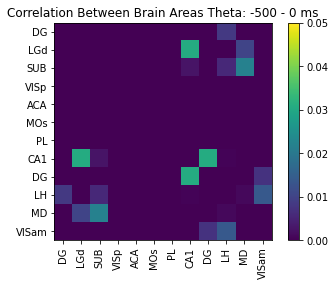

In [271]:
pval[pval > 0.05] = -1
plt.imshow(pval[0:12,0:12])
plt.colorbar()
plt.clim(0,0.05) 
positions = (0,1, 2, 3,4,5,6,7,8,9,10,11)
labels = session11['brain_area_lfp']
plt.xticks(positions, labels,rotation = 'vertical')
plt.yticks(positions, labels)
plt.title('Correlation Between Brain Areas Theta: -500 - 0 ms')

In [272]:
#@title need to bandpass signal for granger (DO NOT DO THIS)
brain_area_1 = concatenate_lfp(session11_lfp[6,:,:],0)
brain_area_2 = concatenate_lfp(session11_lfp[7,:,:],0)

low_freq = 5 
high_freq = 8 
fs = 100 

theta_ba1 = butter_bandpass_filter_good_func(brain_area_1, low_freq, high_freq, fs, order=6)
theta_ba2 = butter_bandpass_filter_good_func(brain_area_2, low_freq, high_freq, fs, order=6)


In [274]:
#@title Testing if concatenated lfp can be considered stationary 
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
print('ADF Test: Brain Area 1')
adf_test(brain_area_1)
print('ADF Test: Brain Area 2')
adf_test(brain_area_2)

ADF Test: Brain Area 1
ADF Statistics: -38.850186
p-value: 0.000000
Critical values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF Test: Brain Area 2
ADF Statistics: -35.972823
p-value: 0.000000
Critical values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [275]:
from statsmodels.tsa.stattools import kpss

def kpss_test(df):    
    statistic, p_value, n_lags, critical_values = kpss(df)
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
        
print('KPSS Test: Brain Area 1')
kpss_test(brain_area_1)
print('KPSS Test: Brain Area 2')
kpss_test(brain_area_2)

KPSS Test: Brain Area 1
KPSS Statistic: 0.2765472914234745
p-value: 0.1
num lags: 65
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: Brain Area 2
KPSS Statistic: 0.522994292057455
p-value: 0.036487772059131764
num lags: 65
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [276]:
rawData = np.column_stack((theta_ba1, theta_ba2))


model = VAR(rawData) #recall that rawData is w/o difference operation

for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue

Lag Order = 1
AIC :  4.078329836268001
BIC :  4.078989871899293
FPE :  59.04676967689827
HQIC:  4.078531615468917 

Lag Order = 2
AIC :  -5.213945392615399
BIC :  -5.212845321671873
FPE :  0.005440167693300025
HQIC:  -5.213609090234552 

Lag Order = 3
AIC :  -9.05344765290253
BIC :  -9.05190753739998
FPE :  0.00011698701024211177
HQIC:  -9.052976824371509 

Lag Order = 4
AIC :  -18.11999983706963
BIC :  -18.11801966776096
FPE :  1.3507782487223172e-08
HQIC:  -18.119394479418094 

Lag Order = 5
AIC :  -21.93449937667624
BIC :  -21.932079144314045
FPE :  2.9782966801750044e-10
HQIC:  -21.93375948693374 

Lag Order = 6
AIC :  -30.842771660900606
BIC :  -30.83991135623718
FPE :  4.028602900426326e-14
HQIC:  -30.841897236096603 

Lag Order = 7
AIC :  -34.59735027241128
BIC :  -34.594049886198604
FPE :  9.431085633293736e-16
HQIC:  -34.59634130957513 

Lag Order = 8
AIC :  -43.152324635965265
BIC :  -43.14858415895501
FPE :  1.8162830470237287e-19
HQIC:  -43.15118113212621 

Lag Order = 9
AI

In [277]:
results = model.fit(maxlags=10, ic='aic')
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/var_model.py:1431: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self._cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 22, Jul, 2021
Time:                     15:11:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -54.9366
Nobs:                     84990.0    HQIC:                  -54.9398
Log likelihood:       2.09358e+06    FPE:                1.37823e-24
AIC:                     -54.9412    Det(Omega_mle):     1.37755e-24
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000000         0.000000            0.010           0.992
L1.y1          9.111357         0.000503        18130.623           0.000
L1.y2         -0.015791              NAN              NAN             NAN
L2.y1        -38.

In [278]:
#@title Still not understanding this granger the best moving on to using a toolbox instead 
!pip install nitime

In [279]:
import nitime
import nitime.analysis as nta
import nitime.timeseries as ts
import nitime.utils as tsu
from nitime.viz import drawmatrix_channels

In [280]:
#Our Data
# TR = .01 #sampling rate
# f_ub = 8 #hz freq 
# f_lb = 5

In [318]:
#original 
TR = 1.89
f_ub = 0.15
f_lb = 0.02

In [282]:
data_path = os.path.join(nitime.__path__[0], 'data')

fname = os.path.join(data_path, 'fmri_timeseries.csv')

data_rec = np.genfromtxt(fname, dtype=float, delimiter=',', names=True)

roi_names = np.array(data_rec.dtype.names)
nseq = len(roi_names)
n_samples = data_rec.shape[0]
data = np.zeros((nseq, n_samples))

for n_idx, roi in enumerate(roi_names):
    data[n_idx] = data_rec[roi]


In [283]:
pdata = tsu.percent_change(data)
time_series = ts.TimeSeries(pdata, sampling_interval=TR)
time_series.shape
# print(time_series)

(31, 250)

In [284]:
G = nta.GrangerAnalyzer(time_series, order=1)

In [285]:
C1 = nta.CoherenceAnalyzer(time_series)
C2 = nta.CorrelationAnalyzer(time_series)

In [286]:
freq_idx_G = np.where((G.frequencies > f_lb) * (G.frequencies < f_ub))[0]
freq_idx_C = np.where((C1.frequencies > f_lb) * (C1.frequencies < f_ub))[0]

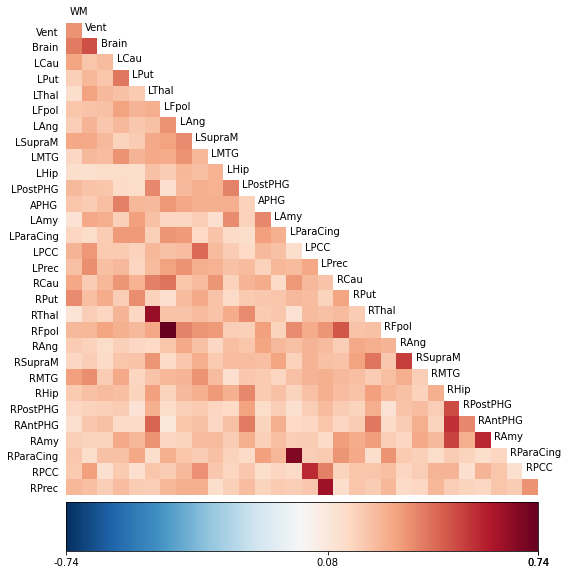

In [287]:
coh = np.mean(C1.coherence[:, :, freq_idx_C], -1)  # Averaging on the last dimension
g1 = np.mean(G.causality_xy[:, :, freq_idx_G], -1)
labels = session11['brain_area_lfp']
fig01 = drawmatrix_channels(coh, roi_names, size=[10., 10.], color_anchor=0)

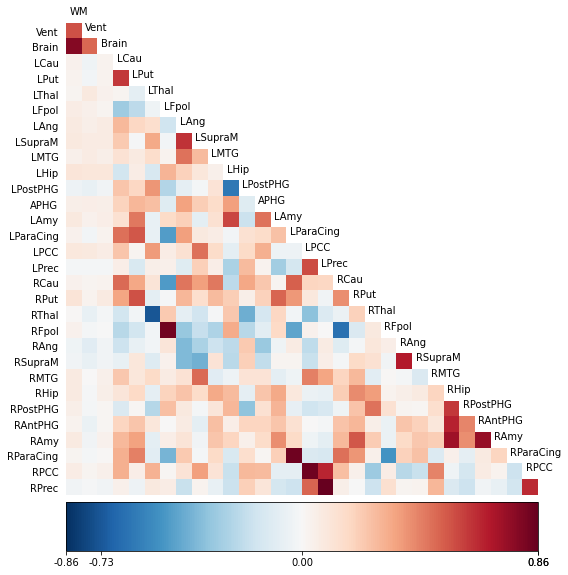

In [288]:
fig02 = drawmatrix_channels(C2.corrcoef, roi_names, size=[10., 10.], color_anchor=0)

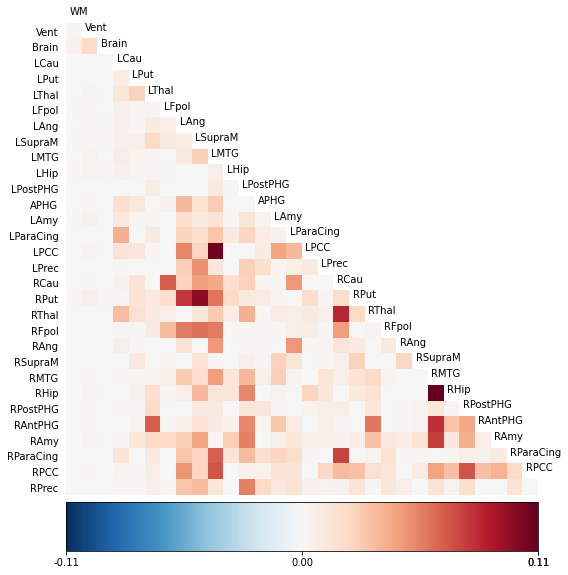

In [289]:
fig03 = drawmatrix_channels(np.transpose(g1), roi_names, size=[10., 10.], color_anchor=0)

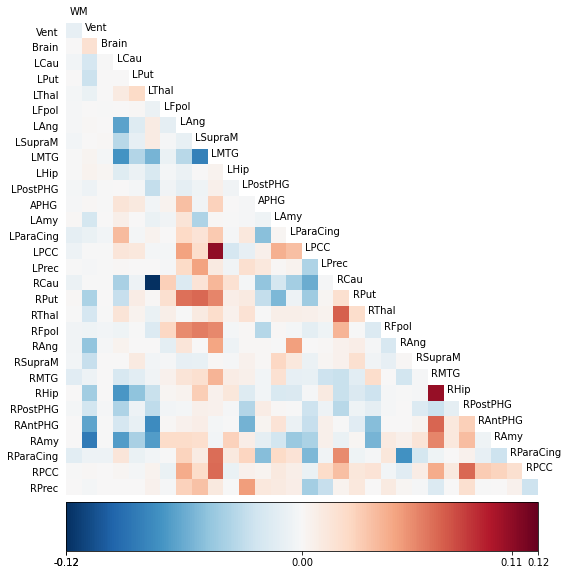

In [290]:
g2 = np.mean(G.causality_xy[:, :, freq_idx_G] - G.causality_yx[:, :, freq_idx_G], -1)
fig04 = drawmatrix_channels(np.transpose(g2), roi_names, size=[10., 10.], color_anchor=0)

Now that the tutorial is fixed can start with our own data 


In [291]:
import nitime
import nitime.analysis as nta
import nitime.timeseries as ts
import nitime.utils as tsu
from nitime.viz import drawmatrix_channels

In [292]:
print(session11_lfp.shape)
print(labels)


(12, 340, 250)
['DG', 'LGd', 'SUB', 'VISp', 'ACA', 'MOs', 'PL', 'CA1', 'DG', 'LH', 'MD', 'VISam']


In [293]:
session11_lfp_avg = np.mean(session11_lfp,axis=1)
session11_lfp_avg.shape

(12, 250)

In [338]:
#original 
TR = .01
f_ub = 8
f_lb = 5



In [339]:
pdata = tsu.percent_change(data)
time_series = ts.TimeSeries(session11_lfp_avg, sampling_interval=TR)
time_series.shape

(12, 250)

In [340]:
G = nta.GrangerAnalyzer(time_series, order=1)

In [341]:
C1 = nta.CoherenceAnalyzer(time_series)
C2 = nta.CorrelationAnalyzer(time_series)

In [342]:
freq_idx_G = np.where((G.frequencies > f_lb) * (G.frequencies < f_ub))[0]
freq_idx_C = np.where((C1.frequencies > f_lb) * (C1.frequencies < f_ub))[0]

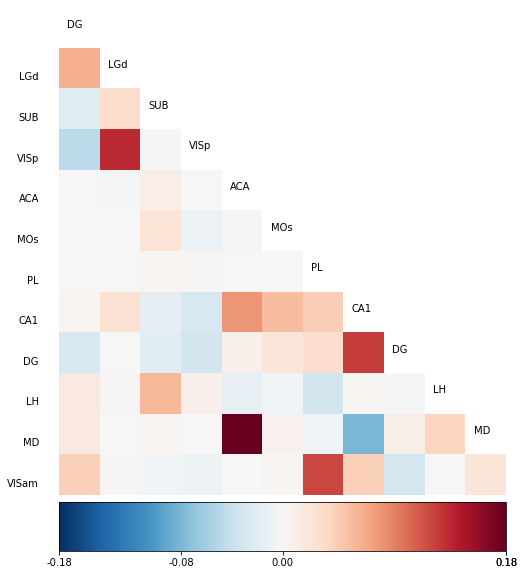

In [343]:
g2 = np.mean(G.causality_xy[:, :, freq_idx_G] - G.causality_yx[:, :, freq_idx_G], -1)
fig01 = drawmatrix_channels(np.transpose(g2), labels, size=[10., 10.], color_anchor=0)

In [349]:
#@title wrapping this process up into a little function 
TR = .01
fb = [5,8]
correct_right_idx = idx['right_cor']

def granger_causality_analysis(averaged_data,TR,freq_band): 
  f_ub = freq_band[1]
  f_lb = freq_band[0]
  pdata = tsu.percent_change(averaged_data)
  time_series = ts.TimeSeries(pdata, sampling_interval=TR)
  G = nta.GrangerAnalyzer(time_series, order=1)
  g2 = np.mean(G.causality_xy[:, :, freq_idx_G] - G.causality_yx[:, :, freq_idx_G], -1)
  return G, g2




In [407]:
#@title Prepping data 
session11_lfp_corr = session11_lfp[:,correct_right_idx==1,:] # pulling correct trials only 
session11_lfp_incorr = session11_lfp[:,correct_right_idx==0,:] #pulling incorrect trials only 
session11_lfp_corr_avg = np.mean(session11_lfp_corr,axis=1) #averaging 
session11_lfp_incorr_avg = np.mean(session11_lfp_incorr,axis=1)


In [396]:
#@title only focusing of areas of interest 
session11_brain_region_idx = [0,1,1,1,1,1,1,1,0,0,1,1]
bool_list = list(map(bool,session11_brain_region_idx))


In [408]:
#@title sorting to relevant areas 
session11_lfp_corr_avg = np.delete(session11_lfp_corr_avg,[0,8,9],axis=0)
session11_lfp_incorr_avg = np.delete(session11_lfp_incorr_avg,[0,8,9],axis=0)

In [422]:
test = np.delete(labels,[0,8,9])


print(np.sum(correct_right_idx == 0))

251


In [409]:
#@title running grangers 

G_corr, g2_corr = granger_causality_analysis(session11_lfp_corr_avg,TR,freq_band=fb)
G_incorr, g2_incorr = granger_causality_analysis(session11_lfp_incorr_avg,TR,freq_band=fb)

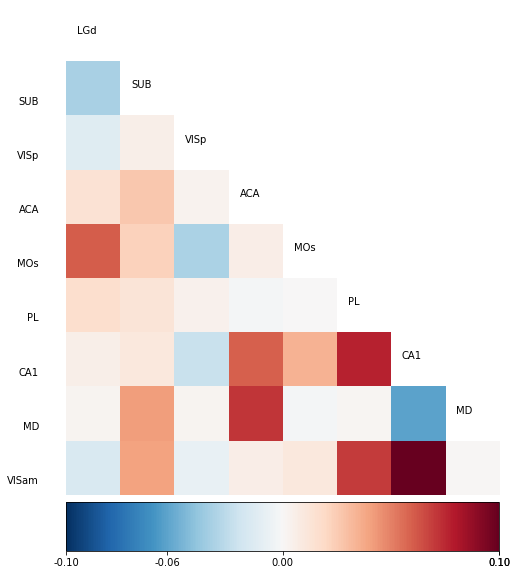

In [418]:
#@title Plotting grangers Correct right trials at theta 
fig01 = drawmatrix_channels(np.transpose(g2_corr), test, size=[10., 10.], color_anchor=0)

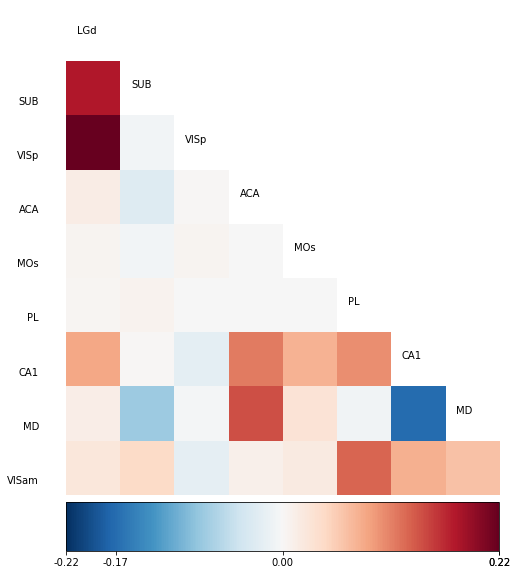

In [419]:
fig02 = drawmatrix_channels(np.transpose(g2_incorr), test, size=[10., 10.], color_anchor=0)

Text(0.5, 1.0, 'Theta Granger Right Correct Trials')

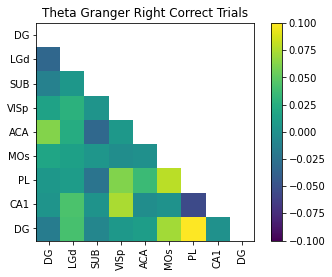

In [415]:
#@title visualizing normal way 
positions = (0,1, 2, 3,4,5,6,7,8,9,10,11)
labels = session11['brain_area_lfp']
plt.xticks(positions, labels,rotation = 'vertical')
plt.yticks(positions, labels)
plt.imshow(np.transpose(g2_corr))
plt.colorbar()
plt.title('Theta Granger Right Correct Trials')


Text(0.5, 1.0, 'Theta Granger Right Inorrect Trials')

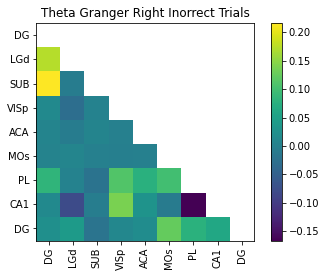

In [413]:

positions = (0,1, 2, 3,4,5,6,7,8)
labels = session11['brain_area_lfp']
plt.xticks(positions, labels,rotation = 'vertical')
plt.yticks(positions, labels)
plt.imshow(np.transpose(g2_incorr))
plt.colorbar()
plt.title('Theta Granger Right Inorrect Trials')


Text(0.5, 1.0, 'Theta Granger Corr - Incorr')

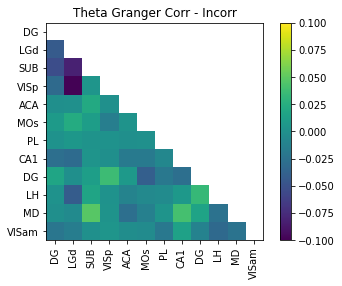

In [331]:
difference_granger = np.subtract(g2_corr,g2_incorr)
positions = (0,1, 2, 3,4,5,6,7,8,9,10,11)
labels = session11['brain_area_lfp']
plt.xticks(positions, labels,rotation = 'vertical')
plt.yticks(positions, labels)
plt.imshow(np.transpose(difference_granger))
plt.colorbar()
plt.clim(-.1,.1) 
plt.title('Theta Granger Corr - Incorr')